# Simple Model Sentiment Analysis

In this notebook, we will test three basic sentiment analysis models and compare their results with our main model. The aim is to evaluate the performance of the basic models and determine to what extent our main model offers improvements in terms of accuracy and reliability in sentiment analysis.

The main model is a `Large Language Model (LLM)`, in particular we use BERT for sentence encoding. The task on which we test all these models is sentiment analysis, in particular we evaluate whether the titles of Amazon reviews indicate a positive or negative review.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier

from Evaluation_Metrics import plot_c_matrix, report_scores

In [2]:
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/angelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preparation

Firstly, we will load the studied and cleaned dataset into the DataFrame `df`. This dataset has been processed in the `Dataset_Analysis.ipynb` file, which can be found in the `Final_Dataset` folder.

At this point we eliminate the 'text' column, as we will only work with the titles of the reviews for the classification task.

In [3]:
#Get the directory of the script
script_directory = os.getcwd()
#Specify the folder name
data_name = '../Final_Dataset/Dataset_final.csv'
#Combine the script directory and folder name to get the full path
data_path = os.path.join(script_directory, data_name)

# Load the dataset into a DataFrame
df=pd.read_csv(data_path)
df=df.drop(columns="text")
df=df.dropna()
df.polarity=df.polarity-1

In [4]:
df.head()

,polarity,title
0,0,bad smell
1,0,forget it!
2,0,oder was faint
3,0,not so flattering!
4,0,transfer and censoring don't matter


We proceed to divide our DataFrame into train set and test set, using 20 per cent of the data for the test set and using the *stratify* command along the 'polarity' column to keep test and train set balanced.

In [5]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['polarity'])

Finally we convert the 'title' and 'polarity' columns from the training and testing datasets into lists, which will be used in our sentiment analysis models. This step ensures that the data is in the correct format for further processing and model training.

In [6]:
TrainTitleX = list(train_data["title"])
TrainY = list(train_data["polarity"])   

TestTitleX = list(test_data["title"])                 
TestY = list(test_data["polarity"])

## Classifier Models

In this section, we will examine our baseline classifiers and analyze their results. The functions defining the metrics we will use are located in the `Evaluation_Metrics.py` file.

### Multinomial Naive Bayes

We start by defining a pipeline for a basic text classification model using the `Multinomial Naive Bayes` algorithm. This pipeline sequentially applies the vectorization, feature selection, and classification steps, making it easy to experiment with different configurations.

Then, we train the model using training data and generate predictions using test data.

In [7]:
# Define the pipeline for the classifier
Model = Pipeline([
    ('vect', CountVectorizer(min_df=5)),                # Feature extractor
    ('sel', SelectKBest(mutual_info_classif, k=5000)),  # Feature selector
    ('learner', MultinomialNB())                        # Learning algorithm
])

# Train the model
Model.fit(TrainTitleX, TrainY)

# Make predictions on the test data
PredictionsModel = Model.predict(TestTitleX)

We now print the results of our model: in particular we show accuracy, precision, recall, f1-score and we see the confusion matrix. We show the confusion matrix in two configurations: normalised and non-normalised. 

In [8]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     20000
           1       0.82      0.80      0.81     19999

    accuracy                           0.82     39999
   macro avg       0.82      0.82      0.82     39999
weighted avg       0.82      0.82      0.82     39999



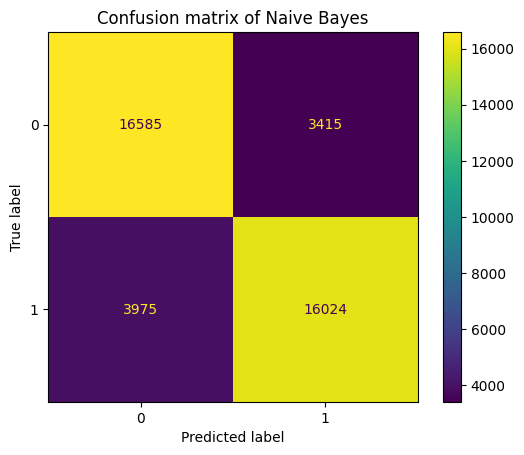

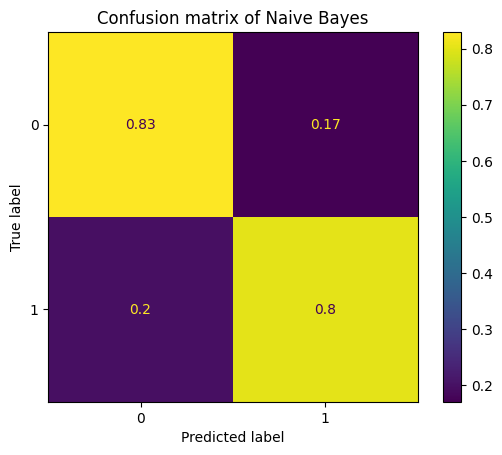

In [11]:
plot_c_matrix(TestY, PredictionsModel, "Naive Bayes")
plot_c_matrix(TestY, PredictionsModel, "Naive Bayes", norm='true')

### Lexicon

With the second model, we employ a `lexicon-based` methodology for sentiment analysis, leveraging the `VADER` (Valence Aware Dictionary and sEntiment Reasoner) lexicon. The code below defines a class constructing our VADER model, which takes text inputs and outputs whether they are associated with negative or positive reviews.


In [12]:
class LexiconVader:
    def __init__(self):
        """
        Initialize the LexiconVader object with a SentimentIntensityAnalyzer instance.
        """
        self.__sid_obj = SentimentIntensityAnalyzer()

    def __call__(self, text):
        """
        Analyze the sentiment of the input text using VADER lexicon.

        Args:
            text (str): The input text to be analyzed.

        Returns:
            int: 1 if the sentiment is positive, 0 if negative.
        """
        # Get the polarity scores for the input text
        result = self.__sid_obj.polarity_scores(text)
        # Extract the positive and negative scores
        pos, neg = result['pos'], result['neg']
        # Return 1 if positive score is greater than or equal to negative score, else return 0
        return 1 if pos >= neg else 0


We then use our model to obtain predictions on our test set. In this approach, there is no need to train the model beforehand.

In [14]:
# Using NumPy's vectorize function, we apply the LexiconVader class to each element of TestTitleX array
Model = np.vectorize(LexiconVader())

# Generate predictions for sentiment using the lexicon-based model
PredictionsModel = Model(np.array(TestTitleX))

And again, we use the previously discussed metrics to evaluate the performance of the model.

In [15]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.88      0.39      0.54     20000
           1       0.61      0.94      0.74     19999

    accuracy                           0.67     39999
   macro avg       0.74      0.67      0.64     39999
weighted avg       0.74      0.67      0.64     39999



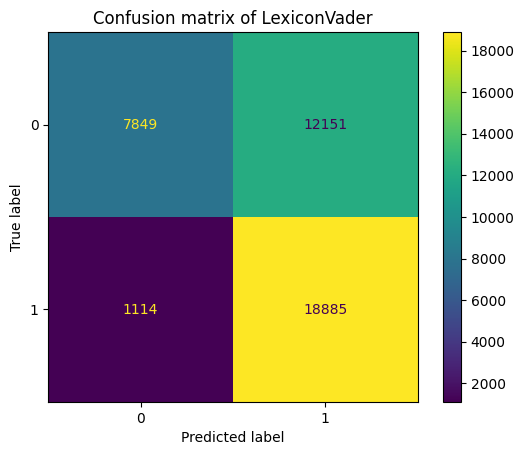

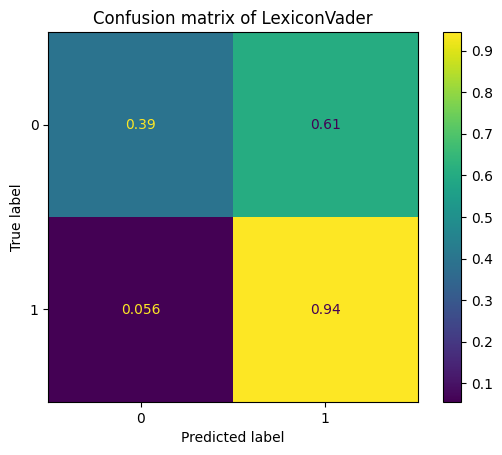

In [16]:
plot_c_matrix(TestY, PredictionsModel, classifier_name="LexiconVader")
plot_c_matrix(TestY, PredictionsModel, classifier_name="LexiconVader", norm='true')

### Multi-Layer Perceptron

As a final basic model, we employ a `Multi-Layer Perceptron (MLP)`. Similar to the Multinomial Naive Bayes model, we define a pipeline that sequentially applies the steps of vectorization, feature selection, and classification. Subsequently, we use this pipeline to train on the training data and make predictions on our test set.

In [17]:
# Define a pipeline for text classification using a Multi-Layer Perceptron (MLP) classifier.
Model = Pipeline([
    ('vect', CountVectorizer(min_df=5)),                      # Feature extractor
    ('sel', SelectKBest(mutual_info_classif, k=5000)),        # Feature selector
    ('learner', MLPClassifier(random_state=1, max_iter=300))  # Learning algorithm
])

# Train the model using the training data.
Model.fit(TrainTitleX, TrainY)

# Generate predictions using the trained model on the test data.
PredictionsModel = Model.predict(TestTitleX)


Finally, we print the results obtained using the same metrics as those used for the other models.

In [18]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82     20000
           1       0.81      0.84      0.83     19999

    accuracy                           0.82     39999
   macro avg       0.83      0.82      0.82     39999
weighted avg       0.83      0.82      0.82     39999



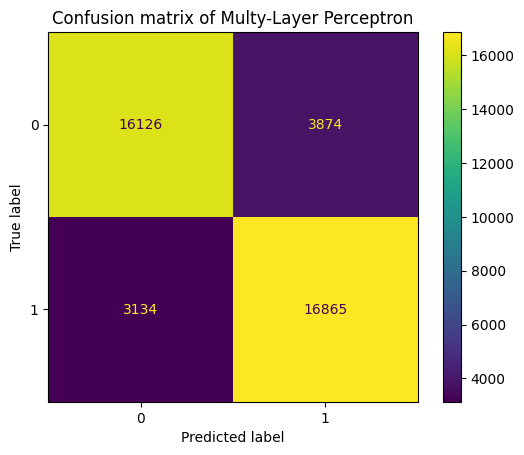

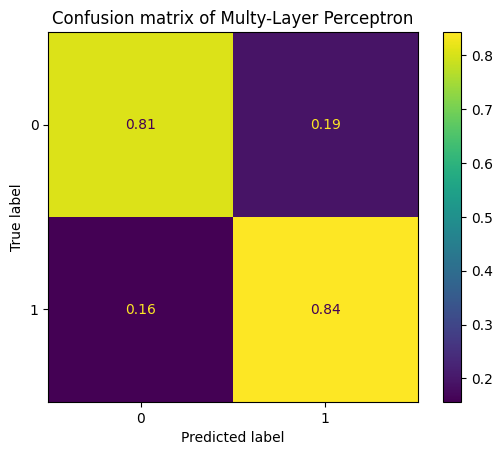

In [19]:
plot_c_matrix(TestY, PredictionsModel, classifier_name="Multy-Layer Perceptron")
plot_c_matrix(TestY, PredictionsModel, classifier_name="Multy-Layer Perceptron", norm='true')

## Conclusion

In this notebook, we analyzed our three basic models for sentiment analysis. From the results obtained, it is evident that the lexicon-based model is the weakest among the three, showing a significant limitation in identifying negative reviews. The other two models appear to be much more balanced: both perform quite well on both negative and positive reviews, achieving an accuracy slightly above eighty percent. Particularly, the multi-layer perceptron model demonstrates slightly superior performance, achieving a final accuracy of 0.82.

Our task now is to demonstrate how our main LLM model outperforms the three models defined above. Indeed, we will see that our main model will achieve better results than all these models and will perform better in all the metrics analyzed above. The main model will be defined in the `Model.py` file and trained in the `Training.py` file. Finally, in the `Test.py` file, we will analyze the obtained results.